In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
path_to_substract12 = "../data/exposure/human_cytb/ms/ms12syn.tsv"
path_to_substract192 = "../data/exposure/human_cytb/ms/ms192syn.tsv"

substract12 = pd.read_csv(path_to_substract12, sep="\t")
substract192 = pd.read_csv(path_to_substract192, sep="\t")


In [28]:
ms12 = pd.read_csv("../data/exposure/human_cytb/pyvolve/out/ms12syn_debug.tsv", sep="\t")
ms192 = pd.read_csv("../data/exposure/human_cytb/pyvolve/out/ms192syn_debug.tsv", sep="\t")

In [29]:
df12 = ms12.merge(substract12[["Mut", "MutSpec"]], on="Mut")
df12["MutSpec"] = df12["MutSpec_x"] - df12["MutSpec_y"]

df192 = ms192.merge(substract192[["Mut", "MutSpec"]], on="Mut")
df192["MutSpec"] = df192["MutSpec_x"] - df192["MutSpec_y"]

In [16]:
from pymutspec.draw import plot_mutspec192, plot_mutspec12

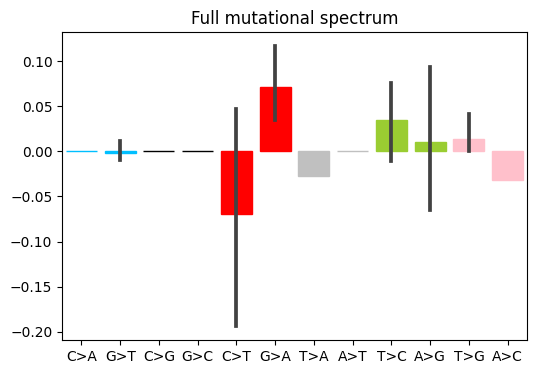

<AxesSubplot:title={'center':'Full mutational spectrum'}>

In [30]:
plot_mutspec12(df12)

In [38]:
ms192.groupby("Mut").ObsNum.sum().sort_values()

Mut
A[A>C]A     0
G[C>G]A     0
G[C>G]C     0
G[C>G]G     0
G[C>G]T     0
           ..
A[A>G]G     8
T[G>A]A     9
A[A>G]T     9
G[C>T]A    12
A[G>A]G    13
Name: ObsNum, Length: 192, dtype: int64

In [21]:
from pymutspec.annotation import calculate_mutspec, rev_comp, transcriptor
from pymutspec.constants import possible_sbs192
import os
import sys
from collections import defaultdict
from functools import reduce, partial

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns



color_mapping12 = {
    "C>A": "deepskyblue",
    "G>T": "deepskyblue",
    "C>G": "black",
    "G>C": "black",
    "C>T": "red",
    "G>A": "red",
    "T>A": "silver",
    "A>T": "silver",
    "T>C": "yellowgreen",
    "A>G": "yellowgreen",
    "T>G": "pink",
    "A>C": "pink",
}
sbs12_ordered = ["C>A", "G>T", "C>G", "G>C", "C>T", "G>A", "T>A", "A>T", "T>C", "A>G", "T>G", "A>C"]
colors12 = [color_mapping12[sbs] for sbs in sbs12_ordered]


kk_lbls = "A>C A>G A>T C>T G>C G>T".split()
cosmic_lbls = "C>A C>G C>T T>A T>C T>G".split()

df = pd.DataFrame({"sbs": possible_sbs192})
df["sbs_base"] = df["sbs"].str.slice(2, 5)
df["sbs_base_revcomp"] = df["sbs_base"].str.translate(transcriptor)
df["sbs_revcomp"] = df["sbs"].apply(rev_comp)
df["is_cosmic"] = df["sbs_base"].isin(cosmic_lbls)
df["is_kk"] = df["sbs_base"].isin(kk_lbls)
df["sbs_base_for_sorting_kp"] = df.apply(
    lambda x: x.sbs_base + "1" if x.is_cosmic else x.sbs_base_revcomp + "2", axis=1)
df["sbs_for_ordering_kk"] = df.apply(lambda x: x.sbs if x.is_kk else x.sbs_revcomp, axis=1)
df["sbs_for_ordering_kp"] = df.apply(lambda x: x.sbs if x.is_cosmic else x.sbs_revcomp, axis=1)

ordered_sbs192_kp = list(df.sort_values(["sbs_base_for_sorting_kp", "sbs_for_ordering_kp"]).sbs.values)
ordered_sbs192_kk = list(df.sort_values(["sbs_base", "sbs_for_ordering_kk"]).sbs.values)
del df


def __prepare_nice_labels(ordered_sbs192):
    _nice_order = []
    prev = None
    for sbs in ordered_sbs192:
        if prev is not None and sbs[2:5] != prev[2:5]:
            _nice_order.append("")
        # _nice_order.append(sbs[2] + sbs[4] + ": " + sbs[0] + sbs[2] + sbs[-1])
        _nice_order.append(sbs)
        prev = sbs
    return _nice_order


In [24]:
def plot_mutspec192(mutspec192: pd.DataFrame, ylabel="MutSpec", title="Mutational spectrum", show=True, figsize=(24, 10), filepath=None):
    """
    Plot barblot of given mutational spectrum calculated from single nucleotide substitutions

    Arguments
    ---------
    mutspec192: pd.DataFrame
        table, containing 192 component mutational spectrum for one or many species, all substitutions must be presented in the table
    title: str, default = 'Mutational spectrum'
        Title on the plot
    filepath: str, default = None
        Path to output plot file. If None no images will be written
    """
    # TODO add checks of mutspec192
    ms192 = mutspec192.copy()
    ms192["MutBase"] = ms192.Mut.str.slice(2, 5)
    ms192["Context"] = ms192.Mut.str.get(0) + ms192.Mut.str.get(2) + ms192.Mut.str.get(-1)
    ms192["long_lbl"] = ms192.Mut.str.get(2) + ms192.Mut.str.get(4) + ": " + \
        ms192.Mut.str.get(0) + ms192.Mut.str.get(2) + ms192.Mut.str.get(-1)
    order = __prepare_nice_labels(ordered_sbs192_kp)

    # df = ms192.groupby(["MutBase", "Context"]).mean()
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.grid(axis="y", alpha=.7, linewidth=0.5)
    sns.boxplot(
        x="Mut", y=ylabel, data=ms192,
        order=order, ax=fig.gca(),
    )
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("")
    # map colors to bars
    width = 0.4
    shift = None
    for bar, sbs in zip(ax.patches, order):
        # if not shift:
        #     shift = (bar.get_width() - width) / 2
        if len(sbs):
            bar.set_color(color_mapping12[sbs[2:5]])
            bar.set_alpha(alpha=0.9)
        # bar.set_width(width)
        # bar.set_x(bar.get_x() + shift)

    plt.xticks(rotation=90, fontsize=6)
    # labels = ['' for _ in ax.get_xticklabels()]
    # ax.set_xticklabels(labels)
    # __label_group_bar_table(ax, df)
    # fig.subplots_adjust(bottom=0.1 * df.index.nlevels)
    if filepath is not None:
        plt.savefig(filepath)
    if show:
        plt.show()
    else:
        plt.close()

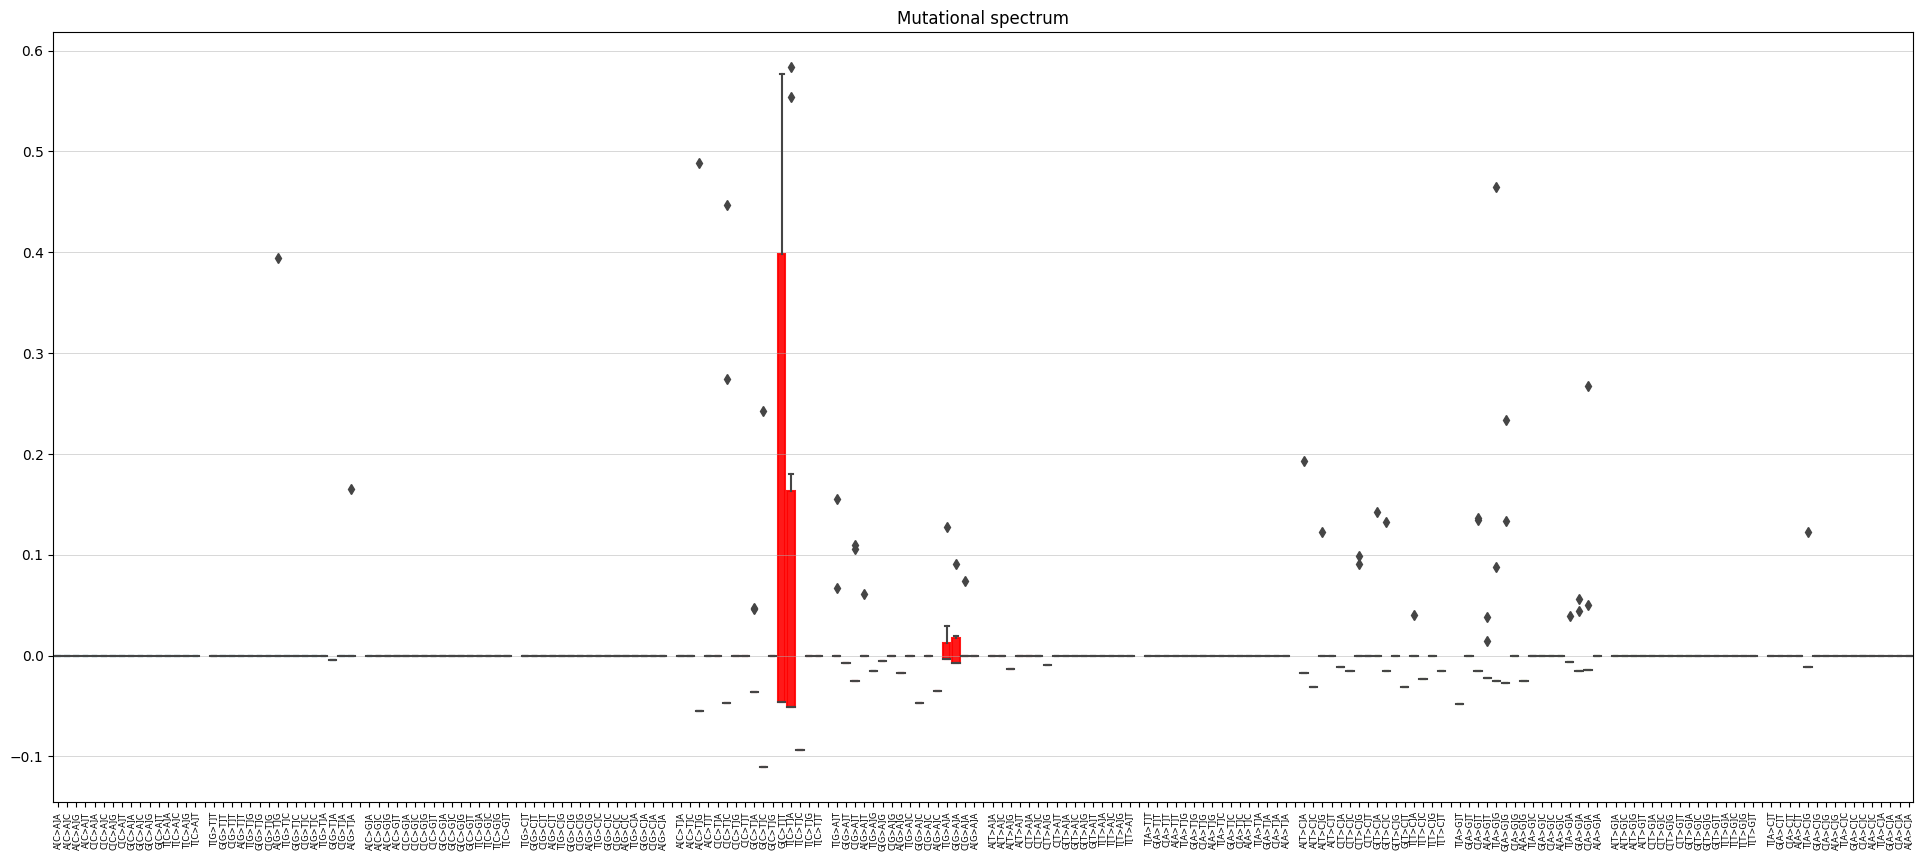

In [25]:
plot_mutspec192(df192)